# Quant 101
## #3 Backtesting de stratégies de trading

## Objectifs du jour
- Comprendre ce qu'est le backtesting et pourquoi c'est crucial en finance quantitative.
- Comprendre la structure et implémenter un backtester simple.
- Implémenter une stratégie de trading basique.
- Analyser les résultats d'un backtest pour évaluer la performance d'une stratégie de trading
- Apprendre les pièges à éviter lors du backtesting.

Selon vous, pourquoi backtester avant de trader ?

## Qu'est-ce qu'un backtest ?

### Définition et rôle
Le backtesting est une simulation **historique**  d'une stratégie qui transforme signaux en position puis en PnL, en respectant l'information disponible à chaque instant t.  
Il permet d'évaluer la performance d'une stratégie avant de l'appliquer en conditions réelles. 


On cherche à valider la plausibilité d'une idée, en estimer la performance, et comprendre ses risques potentiels.  
Ce que le backtesting **n'est pas** : une garantie de succès futur.

### Importance du backtesting
- **Validation de stratégie** : Permet de tester la viabilité d'une stratégie avant de l'exécuter en conditions réelles.
- **Optimisation** : Aide à affiner les paramètres de la stratégie pour maximiser la performance.
- **Gestion des risques** : Identifie les risques potentiels et les points faibles de la stratégie.

## Structure d'un backtester simple
1. **Données historiques** : prix, volumes, dates, etc.
2. **Signal** : règles définissant quand acheter/vendre.
3. **Modèle d'exécution** : comment les ordres sont passés (slippage, frais, sizing, latence).
4. **Portefeuille** : gestion des positions, allocation de capital, leverage.
5. **Moteur de backtesting** : simule l'exécution des trades en fonction de la stratégie et des données. Calcul du PnL, coûts de transaction, etc.
6. **Métriques et diagnostic** : évaluation de la performance à l'aide de métriques (Rendements, Volatilité, Sharpe, MDD, turnover, In/Out of Sample, etc.).
7. **Validation** : tests de robustesse, stress tests, walk-forward analysis.
8. **Reporting** : visualisation des résultats, graphiques de performance, analyse des trades.

Chacune de ces composantes est cruciale pour un backtest réaliste et fiable.

### Données
**Stocker, nettoyer et servir les données au moteur de backtest.**

#### Contenu  
- Prix historiques (OHLCV)
- Données alternatives (sentiment, nouvelles)
- Calendriers boursiers
- Métadonnées (splits, delistings)

#### Fonctionnalités
- Traitement des données
    - Valeures manquantes
    - Timestamps non alignés
- Pas de leakage d'information
    - Assurer que seules les données disponibles à l'instant t sont utilisées pour les décisions à t.

Un signal généré à la fin du jour t ne peut être exécuté qu’au jour t+1.

Connaissez-vous des exemples de signaux ?

---

### Signal
**Définir les règles de trading basées sur les données historiques.**
#### Types de signaux
- Règles simples (moyennes mobiles)
- Modèles stats (z-score, cointegration, mean-reversion)
- Modèles ML (classification, régression)
- Basés sur des événements (annonces de bénéfices, nouvelles économiques)

#### Considérations
- Fréquence du signal (intraday, daily, weekly)
- Horizon de prédiction
- Robustesse (éviter l'overfitting)

---

### Modèle d'exécution
**Simuler comment les ordres sont passés sur le marché.**
#### Choix d'exécution
- Marché vs Limite
- Taille des ordres (fraction du volume, VWAP)
- Slippage (écart entre le prix attendu et le prix réel d'exécution)
- Coûts de transaction (frais fixes, variables)
- Latence (délai entre la génération du signal et l'exécution)

---

### Portefeuille
**Gérer les positions, l'allocation de capital et le risque.**
#### Gestion des positions
- Taille des positions (fixed, risk-based, volatility-scaled)
- Leverage 
- Règles de rééquilibrage (périodique, seuils)

#### Métriques en continue
- PnL (Profit and Loss)
- Exposition
- Rendement cumulatif
- Volatilité
- Rolling drawdown

---

### Moteur de backtesting
**Simuler l'exécution des trades et calculer le PnL.**
#### Étapes
Un event loop :
```python
for t in timeline :
    update_data(t)
    strategy_step(t)
    execute_orders(t)
    update_portfolio(t)
    record_metrics(t)
```

#### Considérations
- Performance (optimisation pour grands datasets)
- Flexibilité (facilité à modifier la stratégie, les paramètres)
- Traçabilité (logs détaillés des trades, décisions)
- Reproductibilité (mêmes résultats avec mêmes données et paramètres)

---

### Métriques et diagnostic
**Évaluer la performance de la stratégie.**
#### Mesures essentielles
- Annualized return
- Annualized vol
- Sharpe, Sortino
- Max Drawdown
- Turnover
- VaR, CVaR

#### Important
Toutes les métriques doivent être ajustées pour les coûts de transaction et le slippage pour refléter la performance réelle.  

---

### Validation
**Tester la robustesse de la stratégie.**
#### Techniques
- Walk-forward analysis
- Tests de stress (scénarios extrêmes)
- Sensitivity analysis (variation des paramètres)
- Bootstrap resampling
- Cross-validation temporelle

Si vous souhaitez en savoir plus sur la validation, voici un article intéressant :  
https://medium.com/@ahmedfahad04/understanding-walk-forward-validation-in-time-series-analysis-a-practical-guide-ea3814015abf

> C'est là que l'on s'assure que la stratégie n'est pas juste "chanceuse" sur les données historiques.

---

### Reporting
**Visualiser et analyser les résultats du backtest.**
#### Visualisations
- Courbes de performance (equity curve)
- Drawdown plots
- Distribution des rendements
- Heatmaps de corrélation
- Analyse des trades (profit/loss par trade, durée des trades)

> On veut rendre le backtest compréhensible en un coup d'œil.

## Implémentation en Python d'un backtester simple
Idéalement, on voudrait construire un backtester modulaire et flexible.  
Mais pour l'atelier, on va implémenter un backtester simple dans un seul notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
from tabulate import tabulate

plt.style.use('seaborn-v0_8-darkgrid')

/var/folders/v3/798pb8p1633962lqdylbcx0r0000gn/T/ipykernel_75870/1594140044.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_prices = yf.download(ticker, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'AAPL Price History'}, xlabel='Date'>

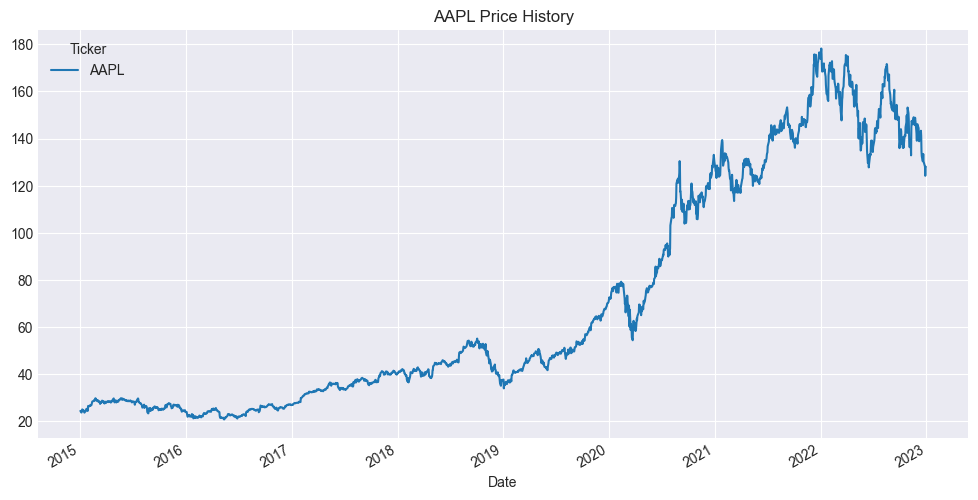

In [2]:
# Préparation des données
start_date = '2015-01-01'
end_date = '2023-01-01'
ticker = 'AAPL'

asset_prices = yf.download(ticker, start=start_date, end=end_date)["Close"]
asset_returns = asset_prices.pct_change().dropna()

asset_prices.plot(title=f'{ticker} Price History', figsize=(12, 6))

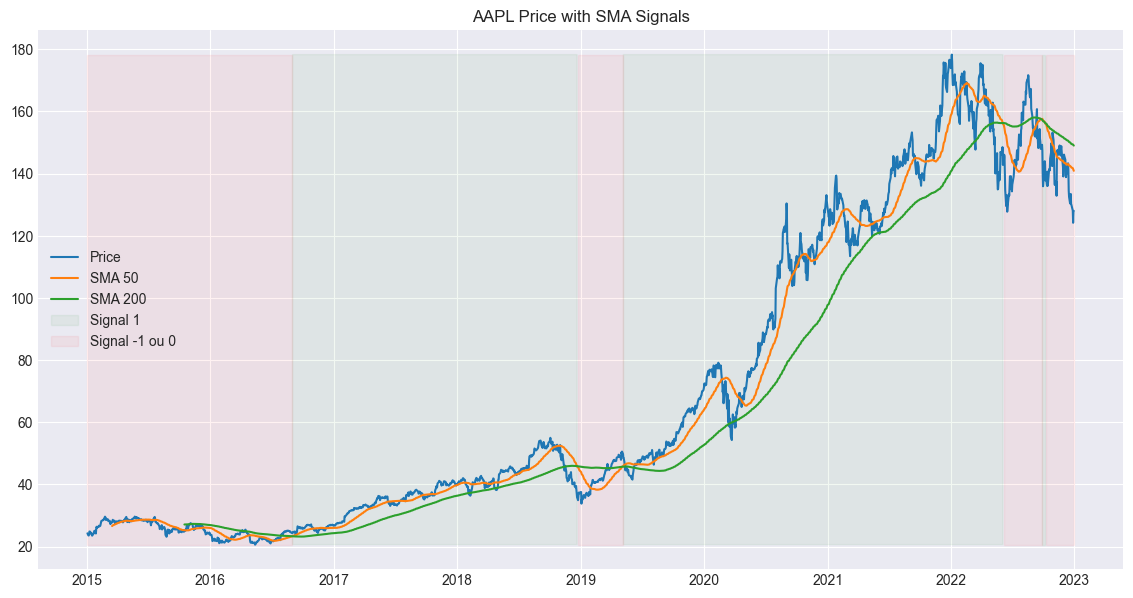

In [ ]:
# Signaux simples (ex : SMA50 > SMA200)
sma_short = asset_prices.rolling(window=50).mean()
sma_long = asset_prices.rolling(window=200).mean()

# Signaux --> Positions
positions = (sma_short > sma_long).astype(int)                            # 1 si SMA10 > SMA30, 0 sinon            (Sans shorting)
# positions = 2 * (sma_short > sma_long).astype(int) - 1                  # 1 pour achat, -1 pour vente            (Avec shorting)

# Le .shift(1) est important!
positions = positions.shift(1).fillna(0)

plt.figure(figsize=(14,7))
plt.plot(asset_prices, label='Price')
plt.plot(sma_short, label='SMA 50')
plt.plot(sma_long, label='SMA 200')

plt.fill_between(asset_prices.index, asset_prices.min(), asset_prices.max(), where=positions[ticker] == 1, color="green", alpha=0.05, label="Signal 1")
plt.fill_between(asset_prices.index, asset_prices.min(), asset_prices.max(), where=positions[ticker] != 1, color="red", alpha=0.05, label="Signal -1 ou 0")

plt.title(f'{ticker} Price with SMA Signals')
plt.legend()
plt.show()

#### Intuition :
- Estimez la performance de cette stratégie simple.
- Est-ce que celle-ci survivra aux coûts de transaction et au slippage ?

In [4]:
# Considérations d'exécution
transaction_cost = 0.001  # 0.1% par transaction

Pas de validation de robustesse avancée, pas de gestion de portefeuille complexe, pas de modèle d'exécution sophistiqué.

On va se concentrer sur l'essentiel pour comprendre le processus de backtesting.

In [5]:
# Portfolio et moteur de backtesting

trades = positions.diff().abs() # Nombre de transactions (changement de position)

returns = positions * asset_returns - (trades * transaction_cost).fillna(0)
equity = (1 + returns).cumprod()

## Visualiation et métriques de performance

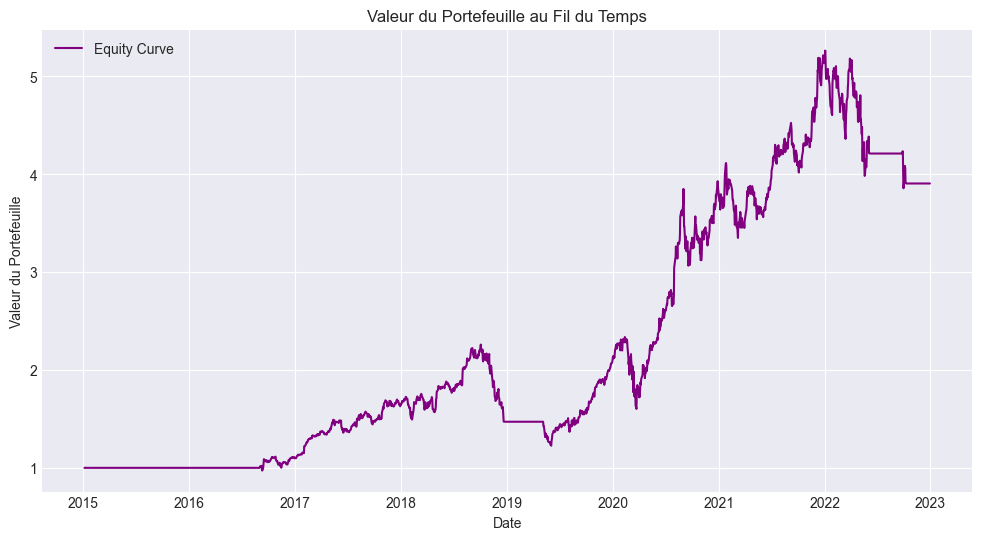

+-------------------+---------+
| Metric            | Value   |
+===================+=========+
| Total Return      | 290.58% |
+-------------------+---------+
| Annualized Return | 18.59%  |
+-------------------+---------+
| Volatility        | 25.00%  |
+-------------------+---------+
| Sharpe Ratio      | 0.74    |
+-------------------+---------+
| Sortino Ratio     | 0.82    |
+-------------------+---------+
| Max Drawdown      | 45.72%  |
+-------------------+---------+
| Turnover          | 0.35%   |
+-------------------+---------+
| 5% VaR            | -2.50%  |
+-------------------+---------+
| 5% CVaR           | -3.86%  |
+-------------------+---------+


In [6]:
# Courbe d'équité
plt.figure(figsize=(12, 6))
plt.plot(equity.index, equity, label='Equity Curve', color='purple')
plt.title('Valeur du Portefeuille au Fil du Temps')
plt.xlabel('Date')
plt.ylabel('Valeur du Portefeuille')
plt.legend()
plt.show()

# Métriques des performances
total_return = (equity.iloc[-1] - 1).item() 
annualized_return = (1 + total_return) ** (252 / len(equity)) - 1

volatility = (returns.std() * np.sqrt(252)).item()
downside_volatility = (returns[returns < 0].std() * np.sqrt(252)).item()

sharpe_ratio = annualized_return / volatility 
sortino_ratio = annualized_return / downside_volatility

drawdown = (equity.cummax() - equity) / equity.cummax()
max_drawdown = drawdown.max().item()

turnover = (trades != 0).sum().item() / len(returns)

VaR = returns.quantile(0.05).item()
CVaR = returns[returns <= VaR].mean().item()

# Format with tabulate
metrics = [
    ["Total Return", f"{total_return:.2%}"],
    ["Annualized Return", f"{annualized_return:.2%}"],
    ["Volatility", f"{volatility:.2%}"],
    ["Sharpe Ratio", f"{sharpe_ratio:.2f}"],
    ["Sortino Ratio", f"{sortino_ratio:.2f}"],
    ["Max Drawdown", f"{max_drawdown:.2%}"],
    ["Turnover", f"{turnover:.2%}"],
    ["5% VaR", f"{VaR:.2%}"],
    ["5% CVaR", f"{CVaR:.2%}"],
]

print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))


## Courbe de drawdown

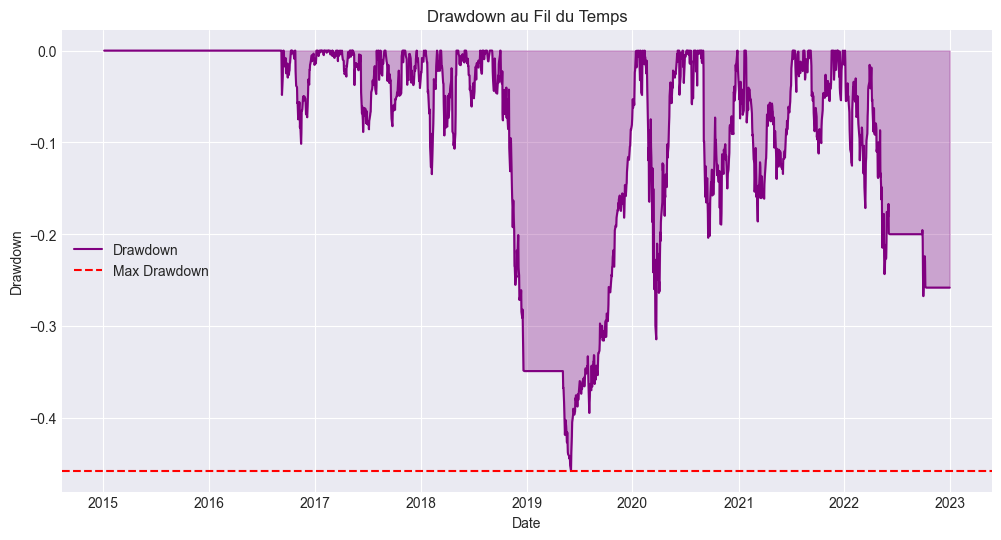

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(drawdown.index, -drawdown, label='Drawdown', color='purple')
plt.fill_between(drawdown.index, 0, -drawdown[ticker], color='purple', alpha=0.3)
plt.title('Drawdown au Fil du Temps')
plt.axhline(y=-max_drawdown, color='red', linestyle='--', label='Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

## Histogramme des rendements

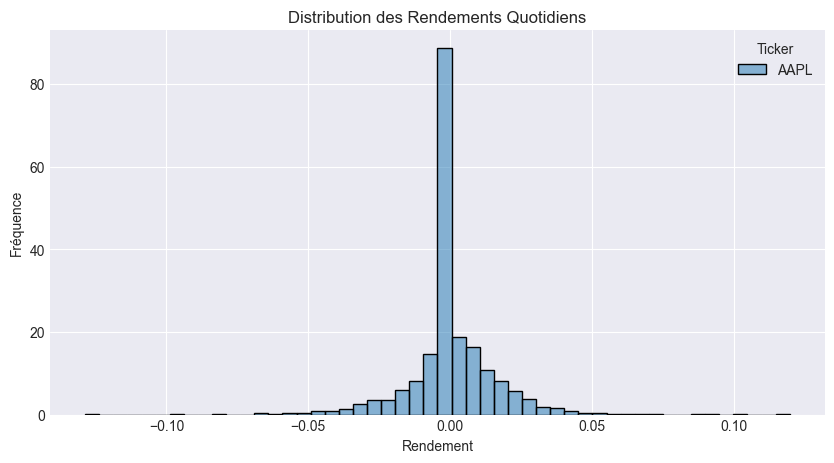

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=50, stat='density', color='purple')
plt.title('Distribution des Rendements Quotidiens')
plt.xlabel('Rendement')
plt.ylabel('Fréquence')
plt.show()


## Positions au fil du temps

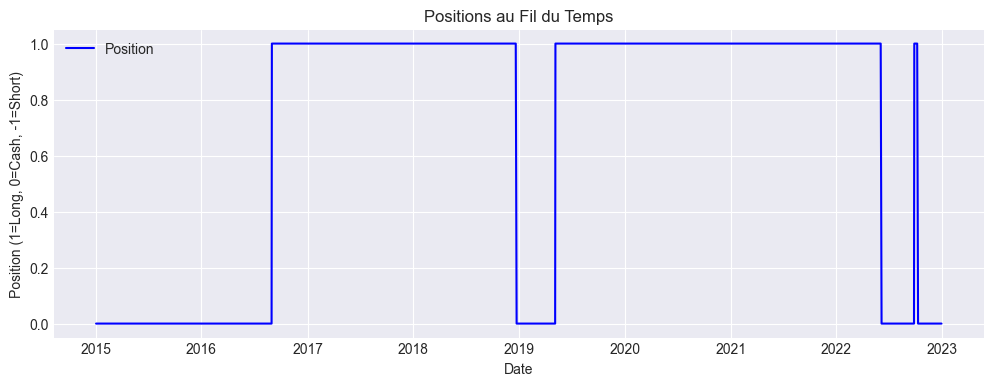

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(positions.index, positions, label='Position', color='blue')
plt.title('Positions au Fil du Temps')
plt.xlabel('Date')
plt.ylabel('Position (1=Long, 0=Cash, -1=Short)')
plt.legend()
plt.show()

Modifions les paramètres pour voir comment cela impacte la performance!

## Risques et pièges du backtesting
- **Look-ahead bias** : Utiliser des données futures pour prendre des décisions passées
- **Sur-optimisation (overfitting)** : Ajuster excessivement la stratégie aux données historiques
- **Survivorship bias** : Ne pas inclure les actifs qui ont échoué ou été retirés du marché
- **Ignorer les coûts de transaction et le slippage** : Sous-estimer les coûts
- **Ne pas valider en Out-of-Sample** : Tester uniquement sur les données utilisées
- **Data-snooping bias** : Tester de multiples stratégies et ne retenir que celles qui fonctionnent bien par hasard.

### Exemple de piège

/var/folders/v3/798pb8p1633962lqdylbcx0r0000gn/T/ipykernel_75870/1992976325.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  intraday_prices = yf.download("AAPL",  interval='1m', start="2025-12-01", end="2025-12-02")["Close"]
[*********************100%***********************]  1 of 1 completed


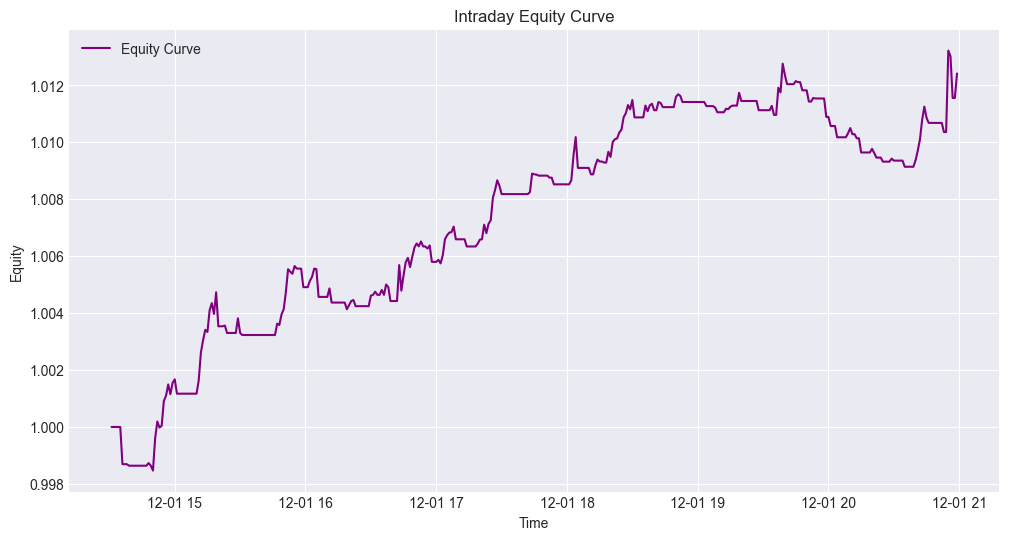

+-------------------+----------+
| Metric            | Value    |
+===================+==========+
| Total Return      | 1.24%    |
+-------------------+----------+
| Annualized Return | 2137.81% |
+-------------------+----------+
| Volatility        | 10.11%   |
+-------------------+----------+
| Turnover          | 27.18%   |
+-------------------+----------+
| Sharpe Ratio      | 211.37   |
+-------------------+----------+


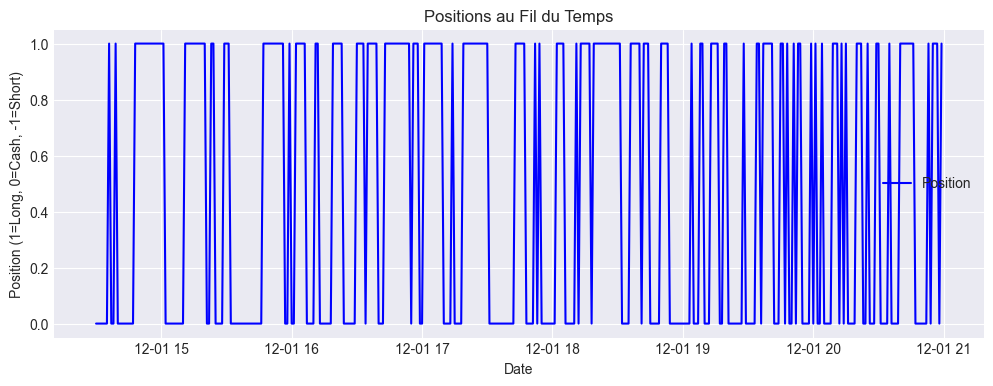

In [10]:
# HFT strategy

intraday_prices = yf.download("AAPL",  interval='1m', start="2025-12-01", end="2025-12-02")["Close"]

sma5 = intraday_prices.rolling(window=5).mean()

positions = (intraday_prices > 1.0001 * sma5).astype(int).shift(1).fillna(0)

trades = positions.diff().abs()
returns = positions * intraday_prices.pct_change() 
equity = (1 + returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(equity.index, equity, label='Equity Curve', color='purple')
plt.title('Intraday Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()

# Métriques des performances HFT
total_return = (equity.iloc[-1] - 1).item() 
annualized_return = (1 + total_return) ** (252 * 6.5 * 60 / len(equity)) - 1  # 6.5 heures de trading
volatility = (returns.std() * np.sqrt(252 * 6.5 * 60)).item()
sharpe_ratio = annualized_return / volatility
turnover = (trades != 0).sum().item() / len(returns)

metrics_hft = [
    ["Total Return", f"{total_return:.2%}"],
    ["Annualized Return", f"{annualized_return:.2%}"],
    ["Volatility", f"{volatility:.2%}"],    
    ["Turnover", f"{turnover:.2%}"],
    ["Sharpe Ratio", f"{sharpe_ratio:.2f}"],
]   
print(tabulate(metrics_hft, headers=["Metric", "Value"], tablefmt="grid"))

plt.figure(figsize=(12, 4))
plt.plot(positions.index, positions, label='Position', color='blue')
plt.title('Positions au Fil du Temps')
plt.xlabel('Date')
plt.ylabel('Position (1=Long, 0=Cash, -1=Short)')
plt.legend()
plt.show()

## Mini-projet
- Choisir une stratégie simple (ex: croisement de moyennes mobiles, momentum, mean-reversion)
- Implémenter la stratégie dans le backtester
- Analyser les résultats et discuter des performances



Avancé : Découpez la période en In-Sample et Out-of-Sample pour valider la robustesse de la stratégie.  
Lien avec l'atelier #2 : On peut déterminer quelle part du rendement de notre stratégie est due au marché (beta) et quelle part est spécifique à la stratégie (alpha) en utilisant une régression linéaire.
